### Python数说指数定投

欢迎关注微信公众号：**python金融量化**（id:tkfy920）

### 基金定投
经管之家博主邢不行老师的文章：《【量化小讲堂-Python、Pandas系列13】数据告诉你：惊人的指数定投策略》  
巴菲特这一辈子曾经无数次的说过：对于个人投资者，最好的投资方式就是指数基金定投。

指数定投是不是时间越长越好？


### Tushare pro
使用方法：安装（进入cmd模式）：pip install tushare  
老版本：import tushare as ts; ts.get_k_data()获取股票行情数据还是挺好用的；   
新版本tushare pro需要注册获取token才能使用，并且获取数据的权限受积分大小影响。   
[tushare pro注册链接地址](https://tushare.pro/register?reg=218422)

In [1]:
import tushare as ts
token='e0eeb08befd1f07516df2cbf9cbd58663f77fd72f92a04f290291c9d'
ts.set_token(token)
pro=ts.pro_api()

In [2]:
import pandas as pd  
import numpy as np
from scipy import stats
import tushare as ts 
import matplotlib.pyplot as plt
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
from datetime import datetime,timedelta
from pyecharts import *

In [3]:
#获取数据并计算对数收益率

def get_index_data(code):
    df=pd.DataFrame()
    df0=pro.index_daily(ts_code=code)
    df[code]=df0.close
    df.index=pd.to_datetime(df0.trade_date)
    df=df.sort_index()
    df['logret']=np.log(df/df.shift(1))
    return df.iloc[1:,:]

In [4]:
#A股常用的八个指数
common_index={'上证综指': '000001.SH',
              '深证成指': '399001.SZ',
              '沪深300': '000300.SH',
              '创业板指': '399006.SZ',
              '上证50': '000016.SH',
              '中证500': '000905.SH',
              '中小板指': '399005.SZ',
              '上证180': '000010.SH'}
#获取指数收盘价和日对数收益率
index_data={}
for name,code in common_index.items():
    index_data[name]=get_index_data(code)

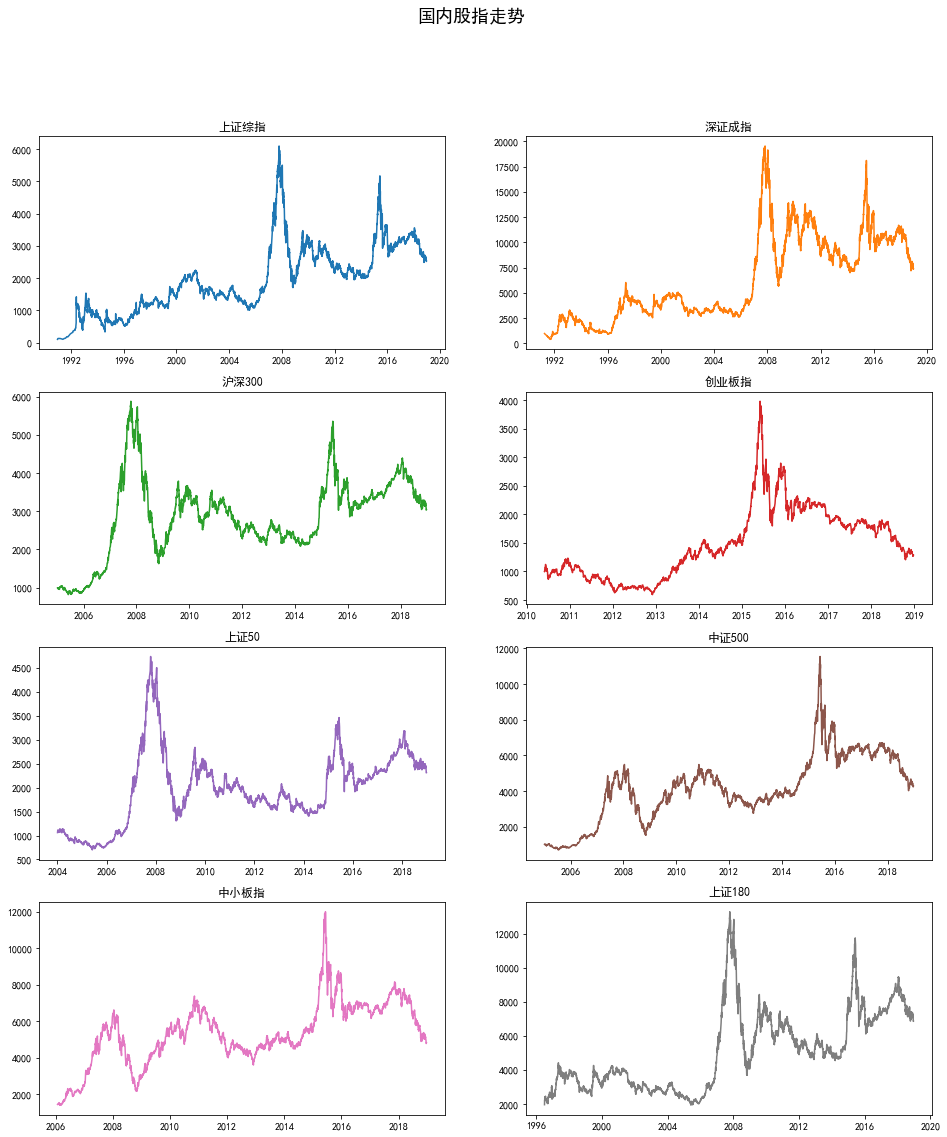

In [5]:
#对股价走势进行可视化
names =list(common_index.keys())
codes=list(common_index.values())

plot_pos = [421,422,423,424,425,426,427,428] # 每个子图的位置
new_colors = ['#1f77b4','#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f','#bcbd22','#17becf']

fig = plt.figure(figsize=(16,18))
fig.suptitle('国内股指走势',fontsize=18)
for i in np.arange(len(plot_pos)):       
    ax = fig.add_subplot(plot_pos[i]) 
    y_data =index_data[names[i]][codes[i]]  
    b = ax.plot(y_data,color=new_colors[i])   
    ax.set_title(names[i])    
plt.show()  

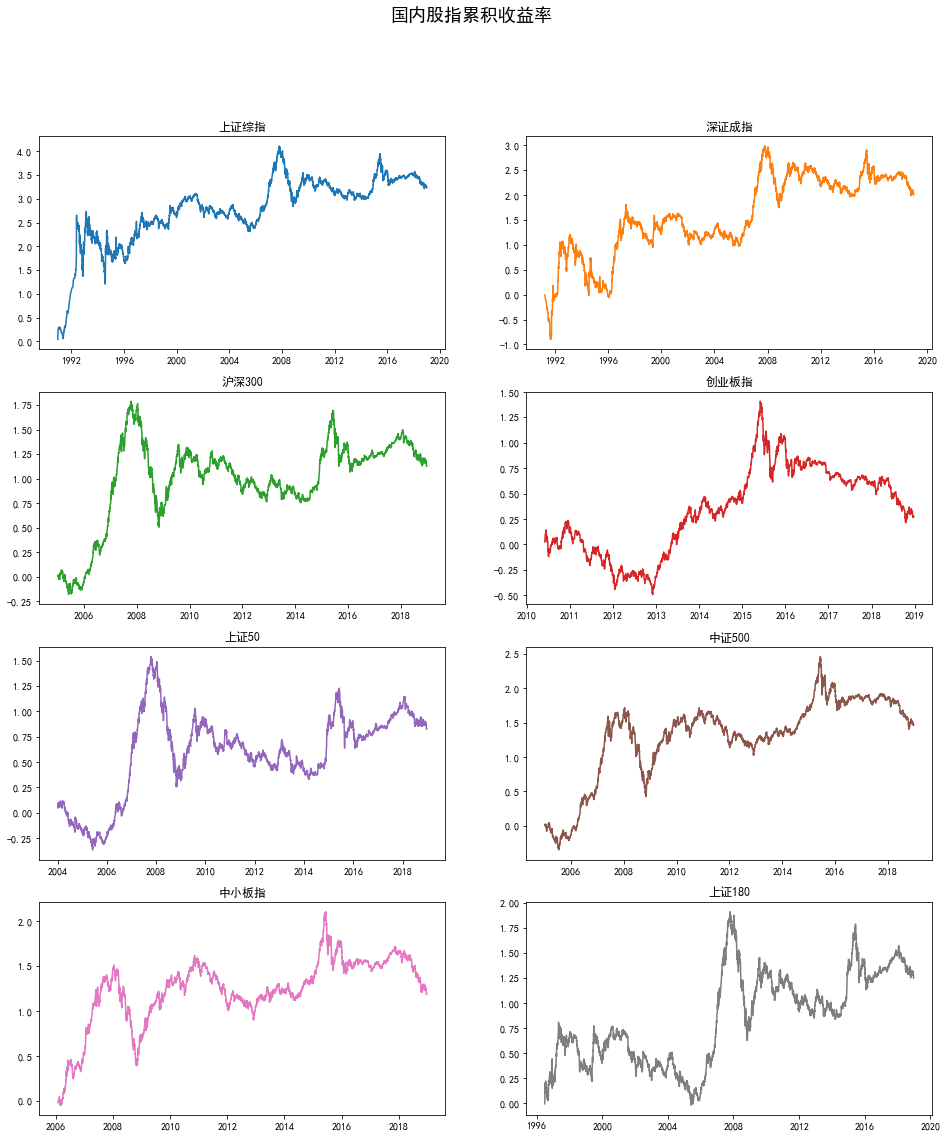

In [6]:
#股指自发行以来累积收益率情况
fig = plt.figure(figsize=(16,18))
fig.suptitle('国内股指累积收益率',fontsize=18)
for i in np.arange(len(plot_pos)):       
    ax = fig.add_subplot(plot_pos[i]) 
    y_data =index_data[names[i]]['logret'].cumsum()  
    b = ax.plot(y_data,color=new_colors[i])   
    ax.set_title(names[i])    
plt.show() 

In [7]:
def cum_return(start_date,end_date='2018-12-24'):
    df=pd.DataFrame()
    for name,data in index_data.items():
        df[name]=data.loc[start_date:end_date]['logret'].cumsum()
    return df

区间收益率情况

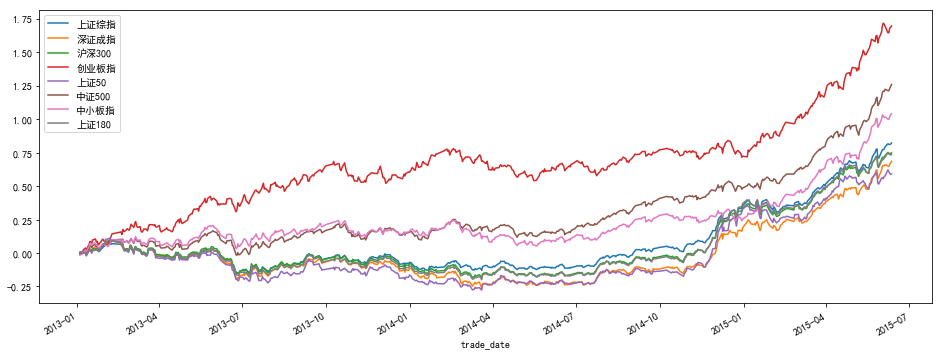

In [173]:
cum_return('2013-01-01','2015-06-12').plot(figsize=(16,6))

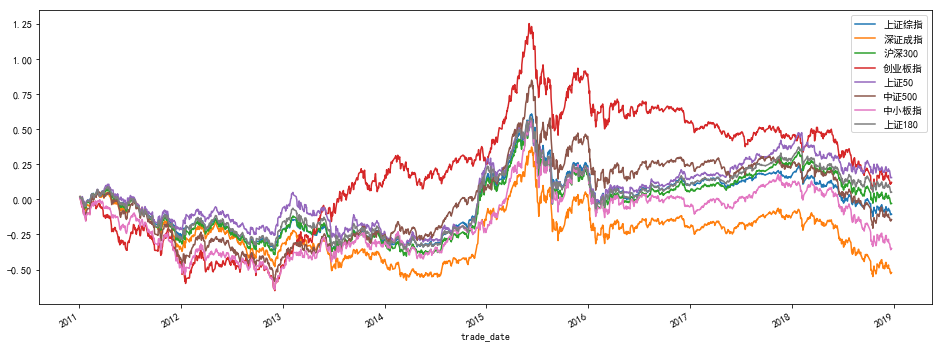

In [52]:
cum_return('2011-01-01').plot(figsize=(16,6))

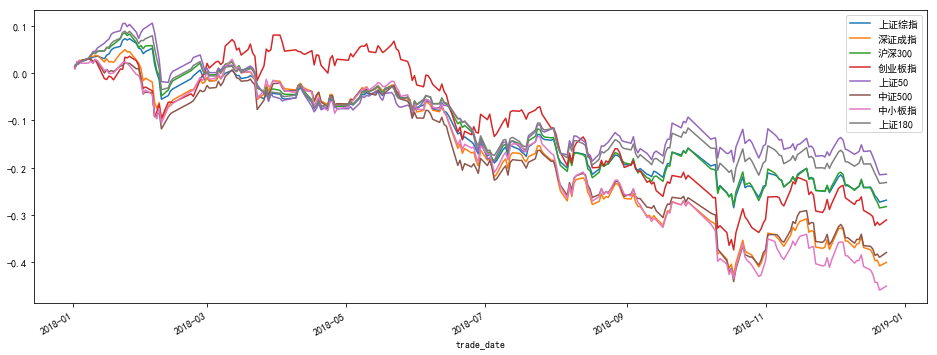

In [51]:
cum_return('2018-01-01').plot(figsize=(16,6))

In [47]:
grid = Grid()
attr = list(common_index)
n=[1/28,1/27,1/13,1/8,1/14,1/13,1/12,1/22]
r=cum_return('1990-12-20').iloc[-1]
v1 = list((r.values*100).round(2))
v2 = ((np.power(1+r.values,n)-1)*100).round(2)

bar = Bar(title="各指数收益率情况")
bar.add("累计收益率%", attr, v1,is_label_show=True)

line = Line()
line.add("年化平均收益率%", attr, v2,is_label_show=True)
overlap = Overlap()
overlap.add(bar)
overlap.add(line, is_add_yaxis=True, yaxis_index=1)

grid.add(overlap, grid_right="15%")
grid

### 指数定投评估

In [73]:
#指数定投函数
def index_strategy(code,start_date,end_date,first=1):

    ##步骤一：获取数据
    ##通过自定义函数get_index_data获取指数数据
    df=get_index_data(code)
    df=df.loc[start_date:end_date]
    #累计收益率
    df['累计收益率']=df.logret.cumsum()
    #假设定投无风险理财产品收益率为4%
    df['无风险收益率']=(4.0/100+1)**(1.0/250)-1
    df['无风险收益_净值']=(df['无风险收益率']+1).cumprod()
    
    ##步骤二：设定定投日并计算份额和累计资金
    #每月第一个交易日或最后一个交易日定投
    #first==1表示每个月第一个交易日定投
    if first==1:
        by_month=df.resample('M',kind='period').first()
    else:
        by_month=df.resample('M',kind='period').last()
    #定投购买指数基金
    trade_log=pd.DataFrame(index=by_month.index)
    #假设每月投入3000元
    trade_log['基金净值']=by_month[code]/3000
    trade_log['money']=3000 
    trade_log['基金份额']=trade_log['money']/trade_log['基金净值']
    trade_log['总基金份额']=trade_log['基金份额'].cumsum()
    trade_log['累计定投资金']=trade_log['money'].cumsum()
    
    ##步骤三：计算定投保本理财份额和资金
    trade_log['理财份额']=trade_log['money']/by_month['无风险收益_净值']
    trade_log['总理财份额']=trade_log['理财份额'].cumsum()
    temp=trade_log.resample('D').ffill()
    df=df.to_period('D')
    
    ##步骤三：计算每个交易日的资产（等于每天的基金份额乘以单位基金净值）和累计收益率
    daily_data=pd.concat([df,temp[['总基金份额','总理财份额','累计定投资金']]],axis=1,join='inner')
    daily_data['指数定投资金']=daily_data[code]/3000*daily_data['总基金份额']
    daily_data['理财定投资金']=daily_data['无风险收益_净值']*daily_data['总理财份额']
    daily_data['指数定投收益率']=(daily_data['指数定投资金']-daily_data['累计定投资金'])/daily_data['累计定投资金']
    daily_data['理财定投收益率']=(daily_data['理财定投资金']-daily_data['累计定投资金'])/daily_data['累计定投资金']
    
    #返回后面分析需要的变量
    return daily_data[[code,'累计收益率','累计定投资金','指数定投资金','理财定投资金','指数定投收益率','理财定投收益率']]

### 微笑曲线
2007年10月16日最高点开始买入，持有至2009年7月31日

In [152]:
#将画图过程封装成函数
def plot_index_ret(code,name,start_date,end_date):
    df=index_strategy(code,start_date,end_date,first=1)
    df1=index_strategy(code,start_date,end_date,first=0)
    print(f'月初开始定投：\n{df.iloc[-1]}')
    print('\n')
    print(f'月末开始定投：{df1.iloc[-1][5]}')
    ax1=df[['累计收益率','指数定投收益率','理财定投收益率']].plot(figsize=(16,6))
    ax1.legend(loc=2)
    plt.title(name+'定投收益率情况\n '+start_date+':'+end_date,fontsize=15)
    ax2 = ax1.twinx()
    df[code].plot(figsize=(16,6),color='r',label=name)
    ax2.legend(loc=1)
    plt.show()

def plot_index_fund(code,name,start_date,end_date):
    #每月定投3000元，期间累计资金情况
    df=index_strategy(code,start_date,end_date,first=1)
    ax1=df[['指数定投资金','理财定投资金']].plot(figsize=(16,6))
    ax2 = ax1.twinx()
    df[code].plot(figsize=(16,6),color='r',label=name)
    ax2.legend(loc=1)
    plt.title(f'累计定投资金情况\n {start_date}:{end_date}',fontsize=15)
    plt.show()

月初开始定投：
000001.SH      5166.350000
累计收益率            -0.164819
累计定投资金       279000.000000
指数定投资金       560899.274207
理财定投资金       324408.522504
指数定投收益率           1.010392
理财定投收益率           0.162755
Name: 2015-06-12, dtype: float64


月末开始定投：1.0202416866220239


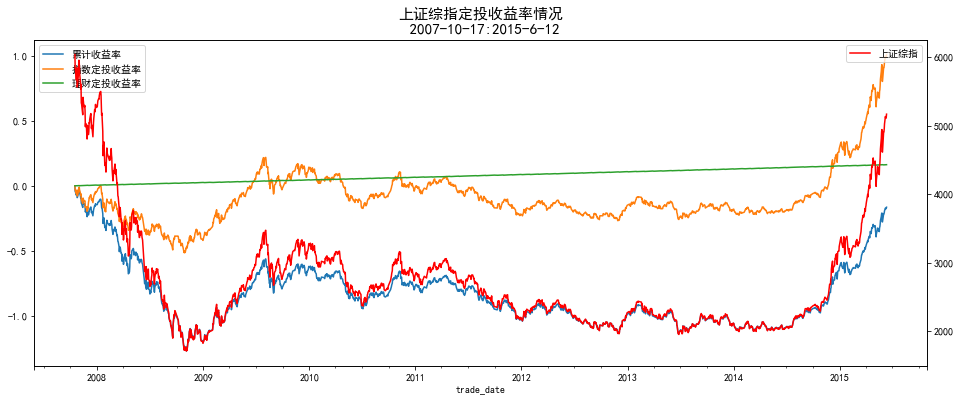

In [153]:
plot_index_ret('000001.SH','上证综指','2007-10-17','2015-6-12')

In [154]:
attr = ["累计收益率 ","月初指数定投收益率","月底指数定投收益率","理财定投收益率"]
v1 = [-16.48, 101.03, 102.02, 16.28]
bar = Bar("上证综指定投收益率情况（%）","2007.10.17—2015.06.12'",title_text_size=15,title_pos='center')
bar.add("", attr, v1,is_label_show=True )
bar

月初开始定投：
000001.SH     3266.920000
累计收益率           -0.623138
累计定投资金       66000.000000
指数定投资金       76325.043857
理财定投资金       68386.525406
指数定投收益率          0.156440
理财定投收益率          0.036159
Name: 2009-07-20, dtype: float64


月末开始定投：0.17958387453914829


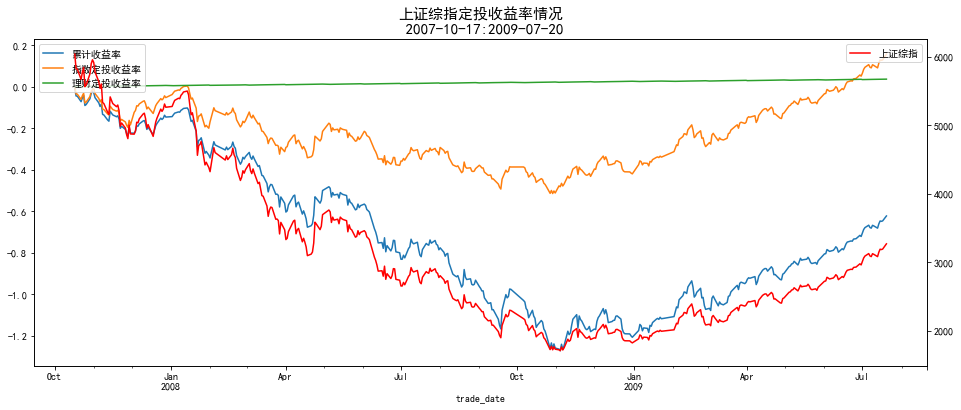

In [164]:
plot_index_ret('000001.SH','上证综指','2007-10-17','2009-07-20')

In [165]:
attr = ["累计收益率 ","月初指数定投收益率","月底指数定投收益率","理财定投收益率"]
v1 = [-62.31, 15.64, 17.96, 3.62]
bar = Bar("上证指数定投收益率情况（%）","2007.10-2009.9",title_text_size=15,title_pos='center')
bar.add("", attr, v1,is_label_show=True )
bar

### 难过曲线


月初开始定投：
000001.SH      2527.007100
累计收益率             0.366036
累计定投资金       441000.000000
指数定投资金       408432.242362
理财定投资金       562838.790741
指数定投收益率          -0.073850
理财定投收益率           0.276278
Name: 2018-12-24, dtype: float64


月末开始定投：-0.0745881151015652


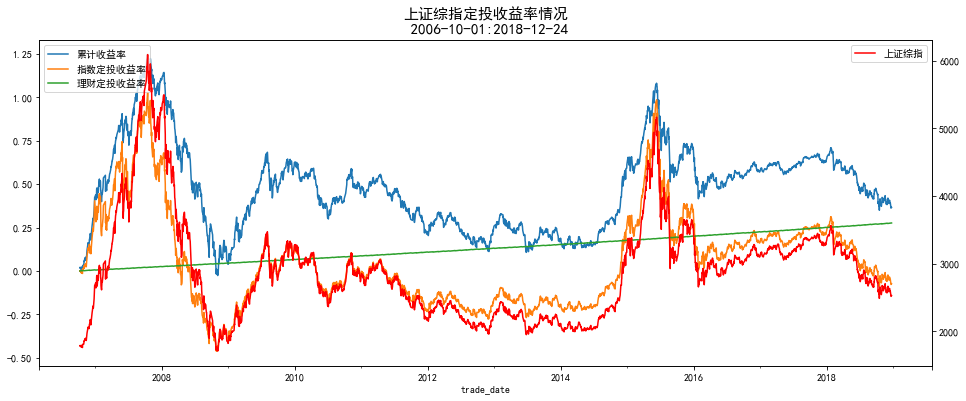

In [167]:
plot_index_ret('000001.SH','上证综指','2006-10-01','2018-12-24')


In [168]:
attr = ["累计收益率 ","月初指数定投收益率","月底指数定投收益率","理财定投收益率"]
v1 = [36.6, -7.39, -7.46, 27.63]
bar = Bar("上证指数定投收益率情况（%）","2006.10-2018.12",title_text_size=15,title_pos='center')
bar.add("", attr, v1,is_label_show=True )
bar

### 单边牛市

月初开始定投：
000001.SH     5166.350000
累计收益率            0.925143
累计定投资金       36000.000000
指数定投资金       65212.824096
理财定投资金       36683.458051
指数定投收益率          0.811467
理财定投收益率          0.018985
Name: 2015-06-12, dtype: float64


月末开始定投：0.6959808976682351


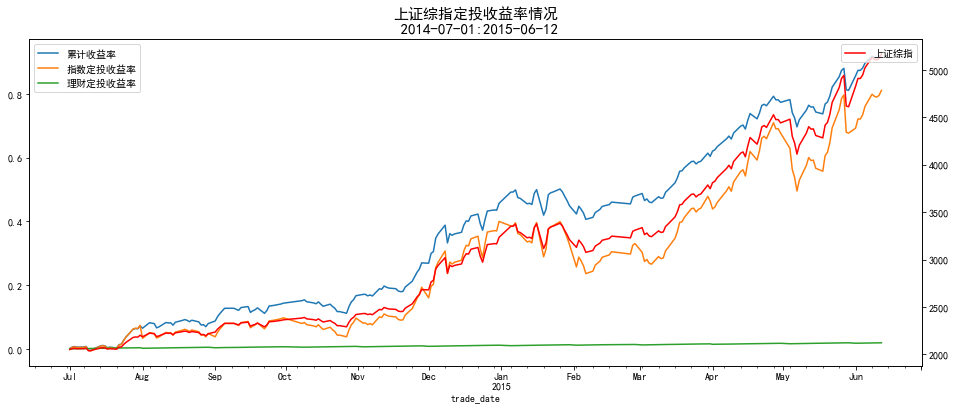

In [138]:
plot_index_ret('000001.SH','上证综指','2014-07-01','2015-06-12')

月初开始定投：
399006.SZ     3899.705000
累计收益率            1.021070
累计定投资金       36000.000000
指数定投资金       80749.649587
理财定投资金       36683.458051
指数定投收益率          1.243046
理财定投收益率          0.018985
Name: 2015-06-12, dtype: float64


月末开始定投：1.1130374881120324


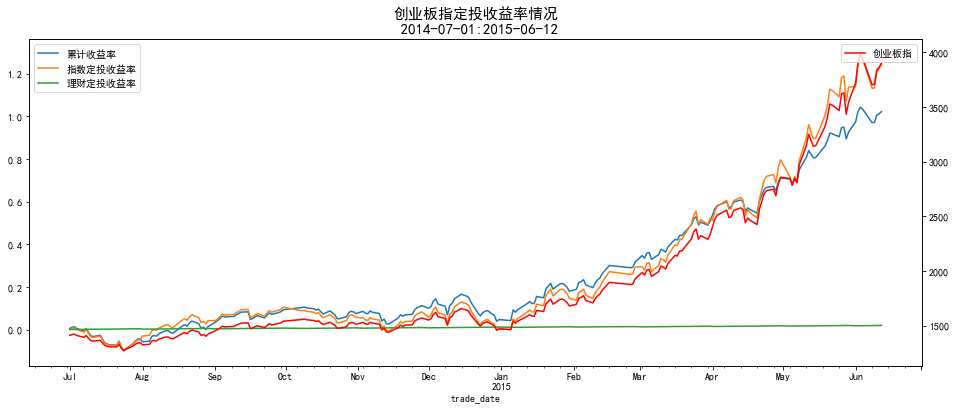

In [140]:
plot_index_ret('399006.SZ','创业板指','2014-07-01','2015-06-12')

In [185]:
#画柱状图函数
def plot_bar_ret(start_date,end_date):
    end_date
    v1=[]
    #定投累计收益率
    v2=[]
    for name,code in common_index.items():
        df=index_strategy(code,start_date,end_date,first=1)
        c=round((df['累计收益率'].iloc[-1])*100,2)
        a=round((df['指数定投收益率'].iloc[-1])*100,2)
        v1.append(c)
        v2.append(a)
    attr=list(common_index.keys())
    bar = Bar("各指数定投vs投入持有" ,f"{start_date}:{end_date}")
    bar.add("一次投累计收益率%", attr, v1, mark_point=["min", "max"])
    bar.add("定投累计收益率%", attr, v2, mark_point=["min", "max"])
    bar

In [194]:
#函数显示不出图形

In [200]:
start_date='2014-07-01'
end_date='2015-06-12'
#一次性投累计收益率
v1=[]
#定投累计收益率
v2=[]
for name,code in common_index.items():
    df=index_strategy(code,start_date,end_date,first=1)
    c=round((df['累计收益率'].iloc[-1])*100,2)
    a=round((df['指数定投收益率'].iloc[-1])*100,2)
    v1.append(c)
    v2.append(a)
attr=list(common_index.keys())
bar = Bar("各指数定投累计收益率" ,"2014.07.01-2015.06.12")
bar.add("一次投入累计收益率%", attr, v1, mark_point=["min", "max"])
bar.add("定投累计收益率%", attr, v2, mark_point=["min", "max"])
bar

In [196]:
start_date='2011-08-01'
end_date='2016-12-24'
#一次性投累计收益率
v1=[]
#定投累计收益率
v2=[]
for name,code in common_index.items():
    df=index_strategy(code,start_date,end_date,first=1)
    c=round((df['累计收益率'].iloc[-1])*100,2)
    a=round((df['指数定投收益率'].iloc[-1])*100,2)
    v1.append(c)
    v2.append(a)
attr=list(common_index.keys())
bar = Bar("各指数定投累计收益率" ,"2011.08.01-2016.12.24")
bar.add("一次投入累计收益率%", attr, v1, mark_point=["min", "max"])
bar.add("定投累计收益率%", attr, v2, mark_point=["min", "max"])
bar

In [197]:
start_date='2011-08-01'
end_date='2018-12-24'
#一次性投累计收益率
v1=[]
#定投累计收益率
v2=[]
for name,code in common_index.items():
    df=index_strategy(code,start_date,end_date,first=1)
    c=round((df['累计收益率'].iloc[-1])*100,2)
    a=round((df['指数定投收益率'].iloc[-1])*100,2)
    v1.append(c)
    v2.append(a)
attr=list(common_index.keys())
bar = Bar("各指数定投累计收益率" ,"2011.08.01-2018.12.24")
bar.add("一次投入累计收益率%", attr, v1, mark_point=["min", "max"])
bar.add("定投累计收益率%", attr, v2, mark_point=["min", "max"])
bar

In [198]:
start_date='2015-06-12'
end_date='2018-12-24'
#一次性投累计收益率
v1=[]
#定投累计收益率
v2=[]
for name,code in common_index.items():
    df=index_strategy(code,start_date,end_date,first=1)
    c=round((df['累计收益率'].iloc[-1])*100,2)
    a=round((df['指数定投收益率'].iloc[-1])*100,2)
    v1.append(c)
    v2.append(a)
attr=list(common_index.keys())
bar = Bar("各指数定投累计收益率" ,"2015.06.12-2018.12.24")
bar.add("一次投入累计收益率%", attr, v1, mark_point=["min", "max"])
bar.add("定投累计收益率%", attr, v2, mark_point=["min", "max"])
bar

In [199]:
start_date='2018-01-01'
end_date='2018-12-24'
#一次性投累计收益率
v1=[]
#定投累计收益率
v2=[]
for name,code in common_index.items():
    df=index_strategy(code,start_date,end_date,first=1)
    c=round((df['累计收益率'].iloc[-1])*100,2)
    a=round((df['指数定投收益率'].iloc[-1])*100,2)
    v1.append(c)
    v2.append(a)
attr=list(common_index.keys())
bar = Bar("各指数定投收益率" ,"2018.01.01-2018.12.24")
bar.add("一次投入累计收益率%", attr, v1, mark_point=["min", "max"])
bar.add("定投累计收益率%", attr, v2, mark_point=["min", "max"])
bar